In [1]:
# Set up
%pylab
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tqdm
import random
import pandas as pd
from collections import Counter
from itertools import cycle

from sklearn import datasets, metrics, tree
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import spectral
import seaborn as sns 
import tqdm

import DecisionTree
import graphviz

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


# Zadanie 2. (1 punkt)
W pakiecie SciKit do Pythona dostępnych jest kilka popularnych algorytmów klasyfikacji danych <br/>
przy użyciu drzew klasyfikacyjnych. Zapoznaj się z nimi wykonując skrypt umieszczony w<br/>
materiałach do wykładu. Do rysowania drzew użyj programu Graphviz.<br/>
<br/>
a) Jaką miarę różnorodności stosuje algorytm konstrukcji drzew klasyfikujących użyty w skrypcie?<br/>
Dla danych Titanic sporządź drzewa klasyfikacyjne stosując indeks Giniego oraz entropię.<br/>
<br/>
b) Podziel dane Titanic na dane uczące i dane testowe (jak w zadaniu 1b), stwórz drzewa<br/>
klasyfikacyjne na danych uczących i przetestuj na danych testowych.<br/>
<br/>
c) Spróbuj ograniczyć głębokość drzewa. Zobacz jak wpływa to na wyniki (zarówno na danych<br/>
uczących jak i na danych testowych).<br/>
<br/>
d) Spróbuj przyciąć drzewo techniką omawianą na wykładzie lub własną. Zobacz jak wpływa to na<br/>
wyniki (zarówno na danych uczących jak i na danych testowych).<br/>
<br/>
e) Zrób cross validation wszystkich tworzonych w tym zadaniu klasyfikatorów na zestawie danych<br/>
Titanic. <br/>



# a) b)


In [2]:
titanic_train = pd.read_csv('data/train.csv')
titanic_test = pd.read_csv('data/test.csv')

X = titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
X = X.dropna()
X['Sex'] = pd.Categorical(X['Sex']).codes
X['Embarked'] = pd.Categorical(X['Embarked']).codes

X.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [18]:
def cross_validation(X, no=10, criterion='gini', max_depth=1000, min_samples_split=None, min_samples_leaf=None):
    err_sum = 0
    Y = X['Survived']
    X = X.drop('Survived', axis=1)
    indices = np.random.uniform(0, no, len(X)).astype(int)
    print('--------------------------------------')
    print(f'Cross validation using {criterion}')
    for i in range(no):
        x_train = X[indices != i]
        y_train = Y[indices != i]
        x_test = X[indices == i]
        y_test = Y[indices == i]
        
        if min_samples_split and min_samples_leaf:
            model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        else:
            model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
            
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        
        result = list(predictions == y_test)
        result_cnt = result.count(True) / len(result) * 100
          
        err_sum += result_cnt
        print(f'Test: {i} -> score: {result_cnt}\n')
        
    print(f'Final error: {err_sum / no}\n')
        
        
def build_Tree(X_train, X_test, criterion='gini', max_depth=1000, min_samples_split=None, min_samples_leaf=None):
    Y_train = X_train['Survived']
    X_train = X_train.drop('Survived', axis=1)
    Y_test = X_test['Survived']
    X_test = X_test.drop('Survived', axis=1)

    model = None
    name = 'titanic.dot'
    if min_samples_split and min_samples_leaf:
        model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    else:
        model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
        
    model.fit(X_train, Y_train)
    print(f'Classification using {criterion} on TEST')
    print(metrics.confusion_matrix(model.predict(X_test), Y_test))
    print(f'Score: {model.score(X_test, Y_test) * 100:.2f}%\n')
    print(f'\nClassification using {criterion} on TRAIN')
    print(metrics.confusion_matrix(model.predict(X_train), Y_train))
    print(f'Score: {model.score(X_train, Y_train) * 100:.2f}%\n\n')
    
    return model, X_train

def draw_tree(tree_,feature_names, target_names, name):
    dot_data = tree.export_graphviz(tree_, out_file=None) 
    graph = graphviz.Source(dot_data) 
    graph.render(name) 
    dot_data = tree.export_graphviz(tree_, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph 

In [20]:
X_train, X_test = train_test_split(X, test_size=0.3333)
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini')
entropy_tree, entropy_X  = build_Tree(X_train, X_test, criterion='entropy')

cross_validation(X, criterion='entropy')
cross_validation(X, criterion='gini')

Classification using gini on TEST
[[121  29]
 [ 31  57]]
Score: 74.79%


Classification using gini on TRAIN
[[272   4]
 [  0 198]]
Score: 99.16%


Classification using entropy on TEST
[[121  26]
 [ 31  60]]
Score: 76.05%


Classification using entropy on TRAIN
[[272   4]
 [  0 198]]
Score: 99.16%


--------------------------------------
Cross validation using entropy
Test: 0 -> score: 80.88235294117648

Test: 1 -> score: 77.14285714285715

Test: 2 -> score: 72.58064516129032

Test: 3 -> score: 81.94444444444444

Test: 4 -> score: 83.14606741573034

Test: 5 -> score: 79.74683544303798

Test: 6 -> score: 76.92307692307693

Test: 7 -> score: 76.66666666666667

Test: 8 -> score: 75.0

Test: 9 -> score: 72.15189873417721

Final error: 77.61848448724575

--------------------------------------
Cross validation using gini
Test: 0 -> score: 79.48717948717949

Test: 1 -> score: 72.28915662650603

Test: 2 -> score: 75.0

Test: 3 -> score: 77.14285714285715

Test: 4 -> score: 82.35294117647058

Te

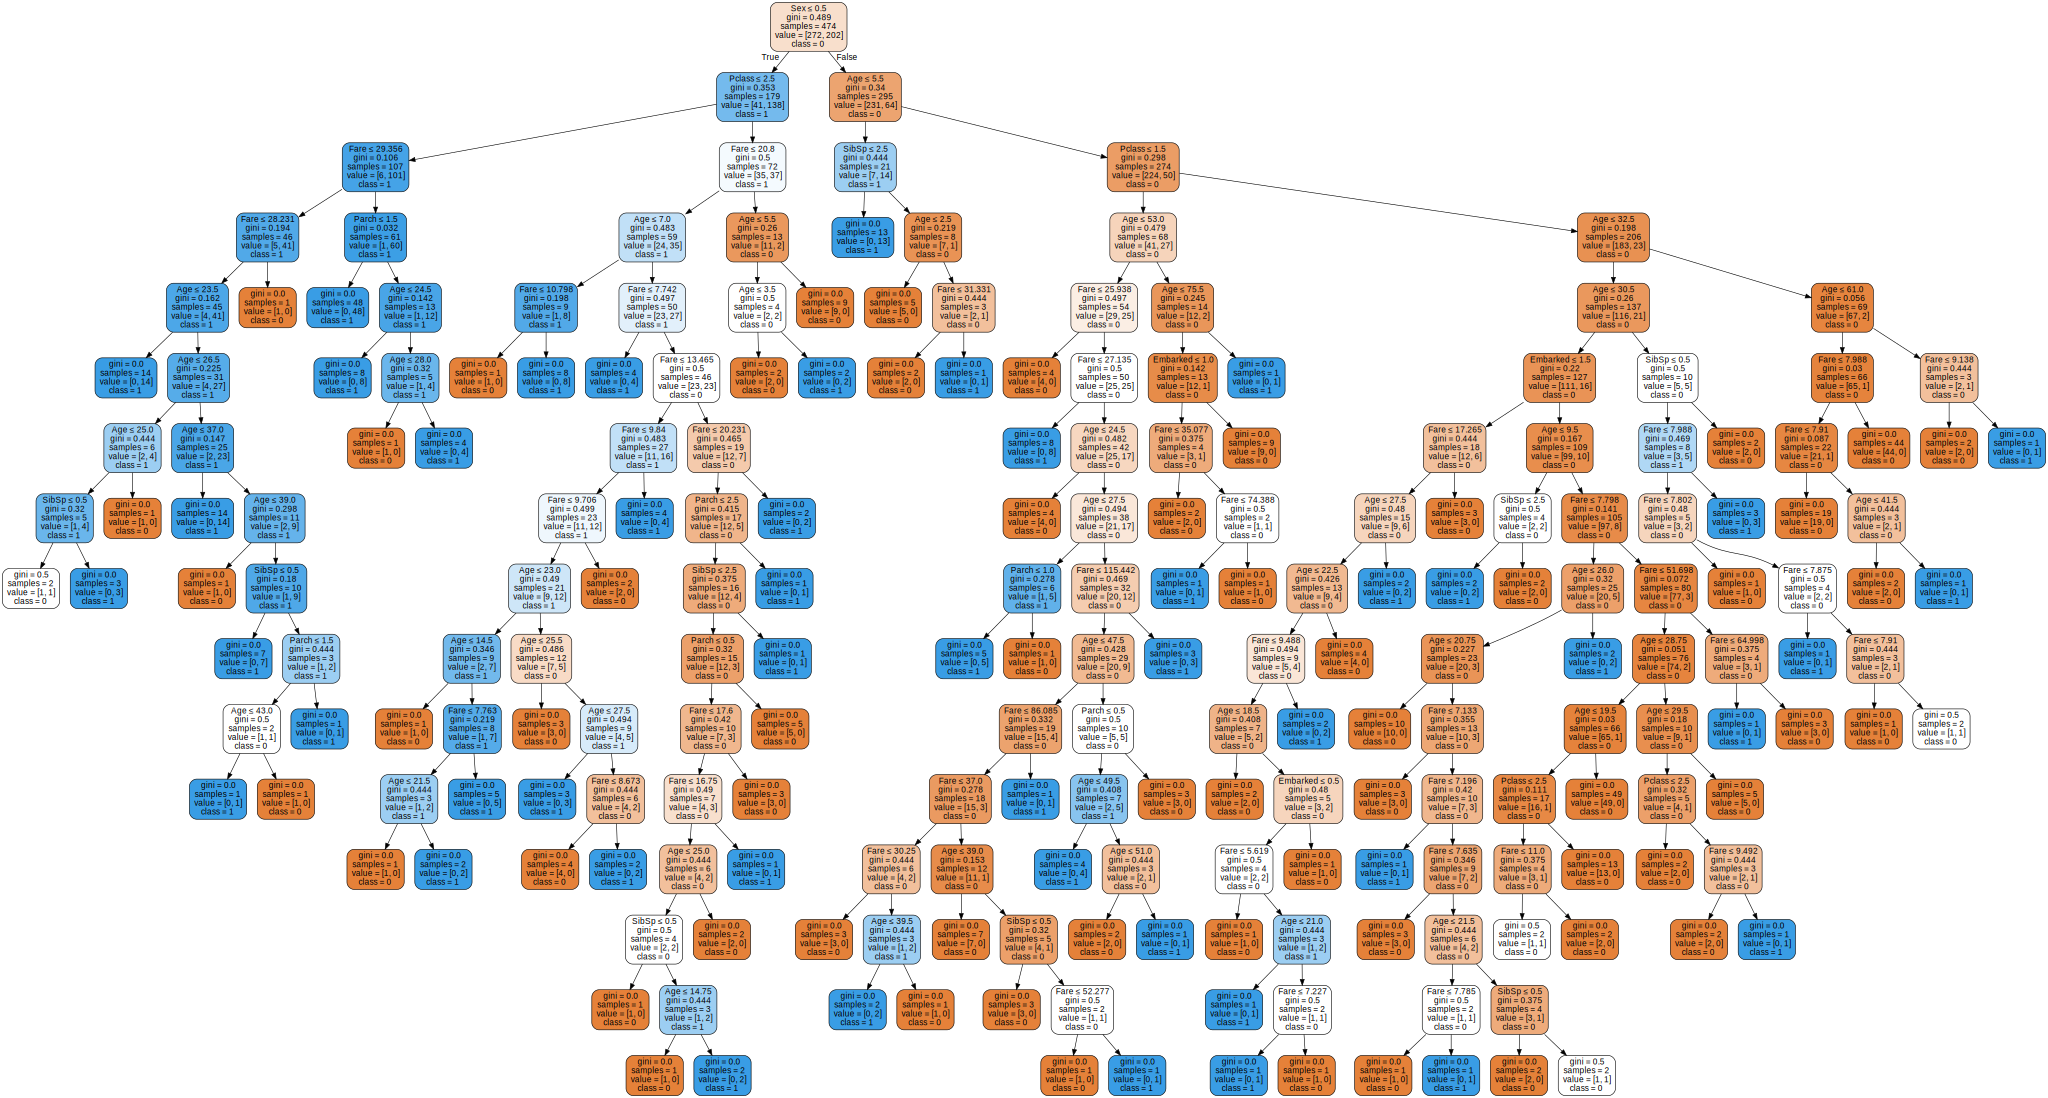

In [21]:
draw_tree(gini_tree, gini_X.columns, ['0','1'], 'titanic_gini')

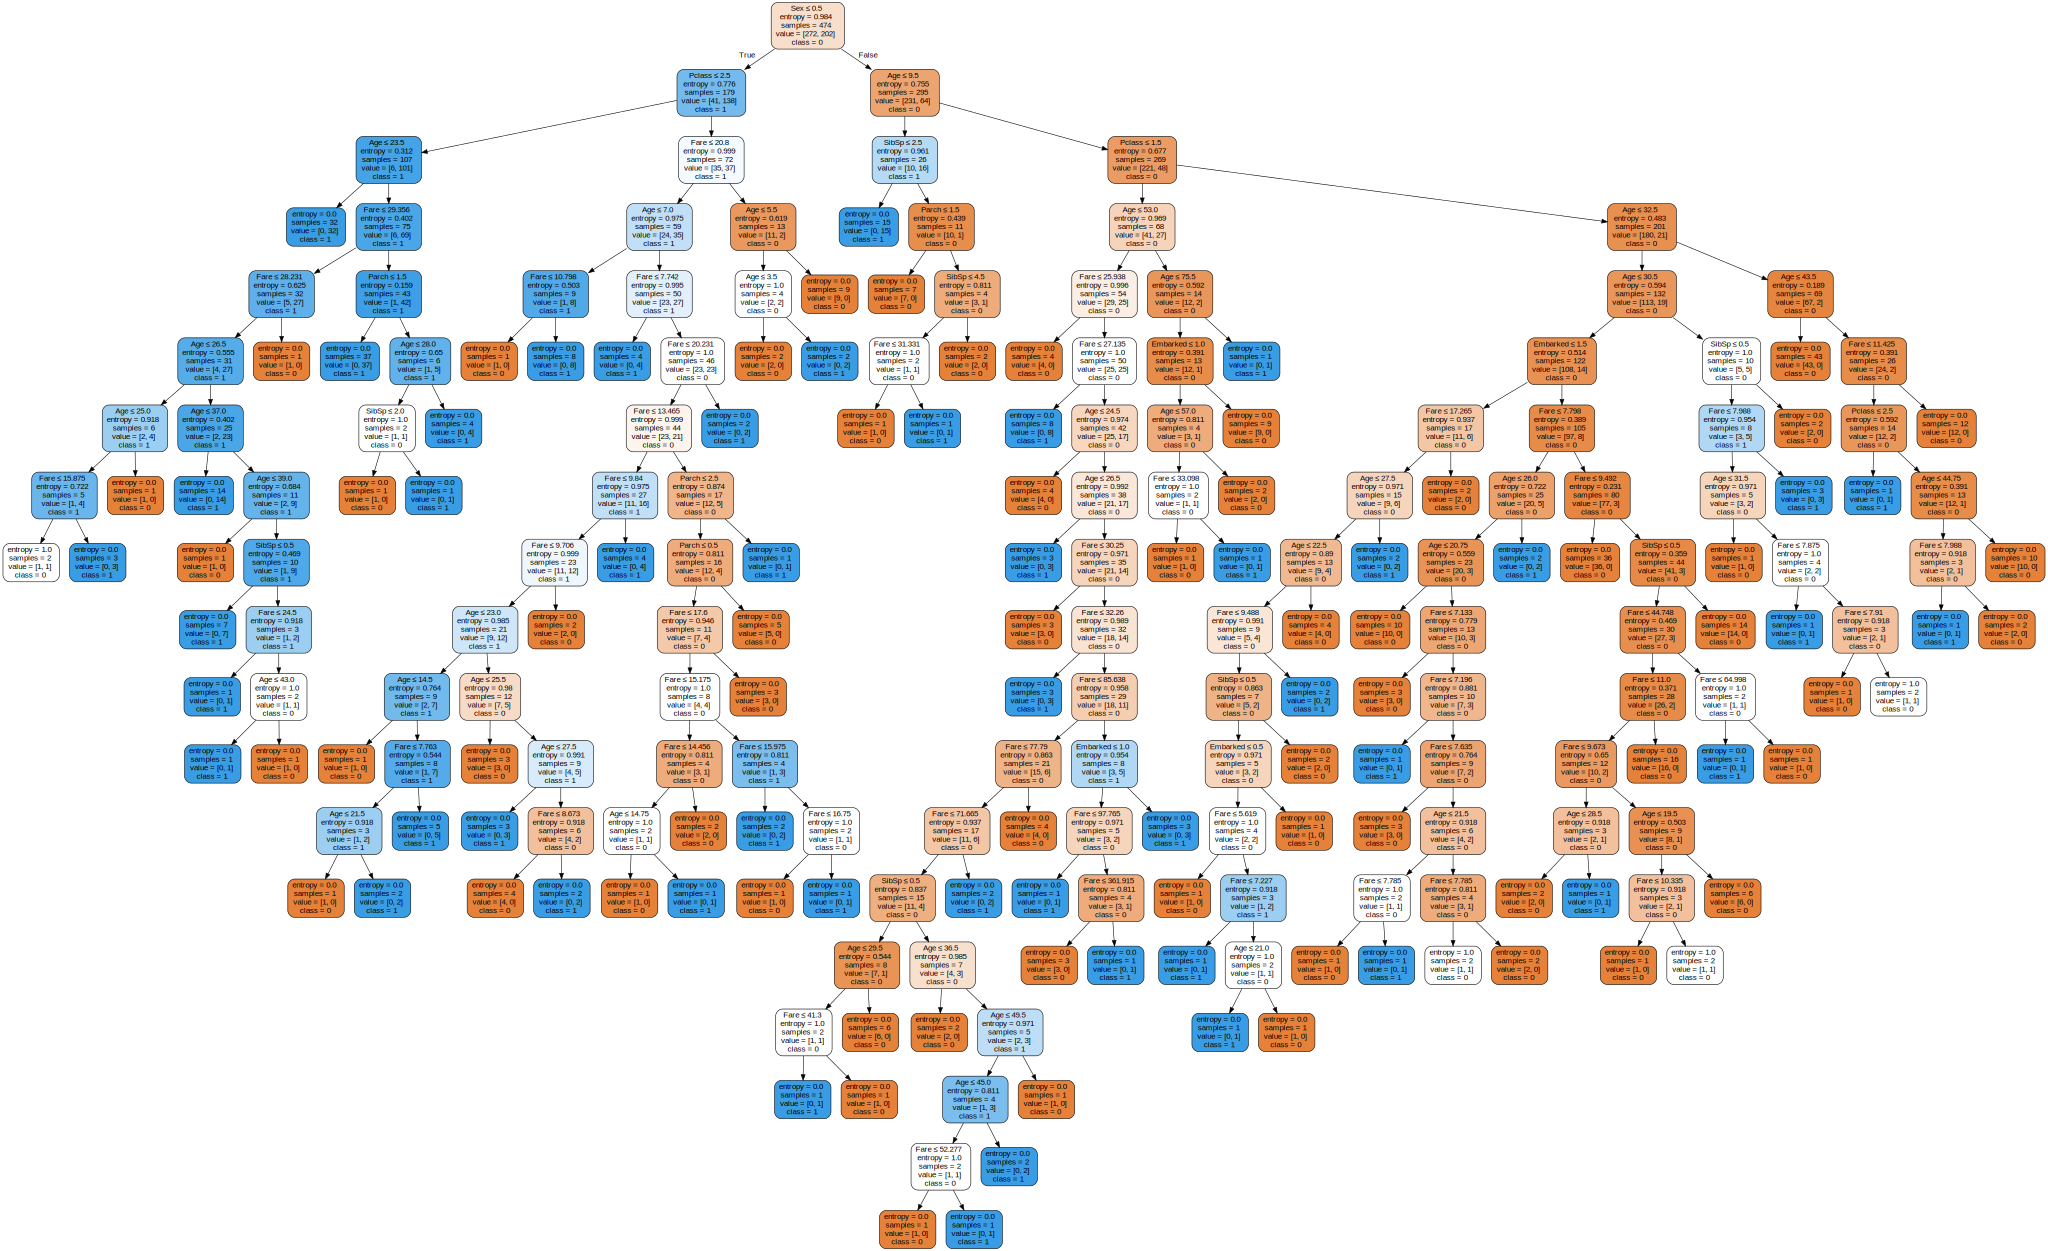

In [22]:
draw_tree(entropy_tree, entropy_X.columns, ['0','1'], 'titanic_entropy')

# c)

In [23]:
# max depth limit
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini', max_depth=5)
entropy_tree, entropy_X = build_Tree(X_train, X_test, criterion='entropy', max_depth=5)

cross_validation(X, criterion='entropy', max_depth=5)
cross_validation(X, criterion='gini', max_depth=5)

Classification using gini on TEST
[[148  35]
 [  4  51]]
Score: 83.61%


Classification using gini on TRAIN
[[267  73]
 [  5 129]]
Score: 83.54%


Classification using entropy on TEST
[[148  32]
 [  4  54]]
Score: 84.87%


Classification using entropy on TRAIN
[[267  71]
 [  5 131]]
Score: 83.97%


--------------------------------------
Cross validation using entropy
Test: 0 -> score: 73.13432835820896

Test: 1 -> score: 79.71014492753623

Test: 2 -> score: 81.9672131147541

Test: 3 -> score: 90.78947368421053

Test: 4 -> score: 84.0

Test: 5 -> score: 82.89473684210526

Test: 6 -> score: 73.23943661971832

Test: 7 -> score: 73.97260273972603

Test: 8 -> score: 81.81818181818183

Test: 9 -> score: 79.48717948717949

Final error: 80.10132975916207

--------------------------------------
Cross validation using gini
Test: 0 -> score: 75.0

Test: 1 -> score: 77.77777777777779

Test: 2 -> score: 77.33333333333333

Test: 3 -> score: 80.3030303030303

Test: 4 -> score: 75.32467532467533

Test

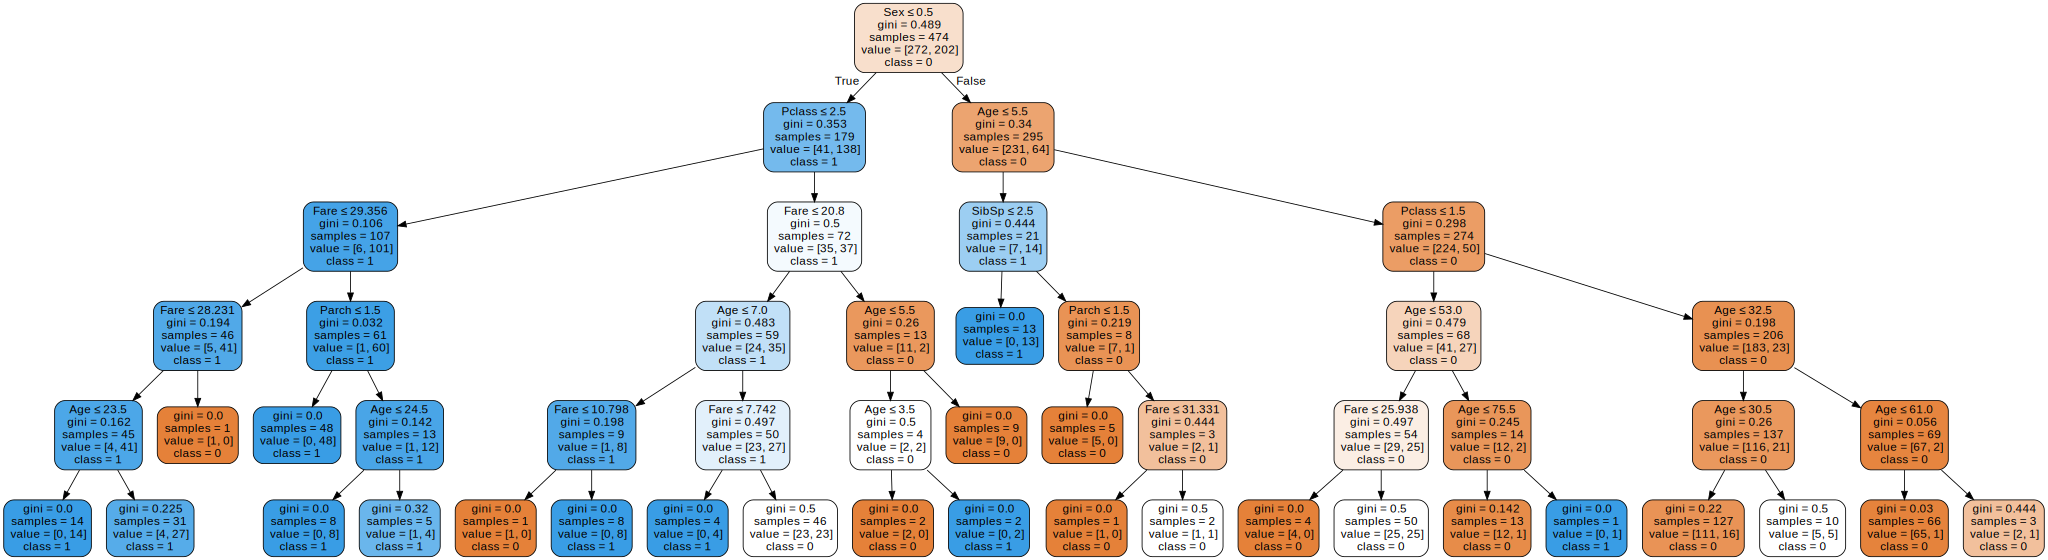

In [24]:
draw_tree(gini_tree, gini_X.columns, ['0','1'], 'titanic_gini_depth')

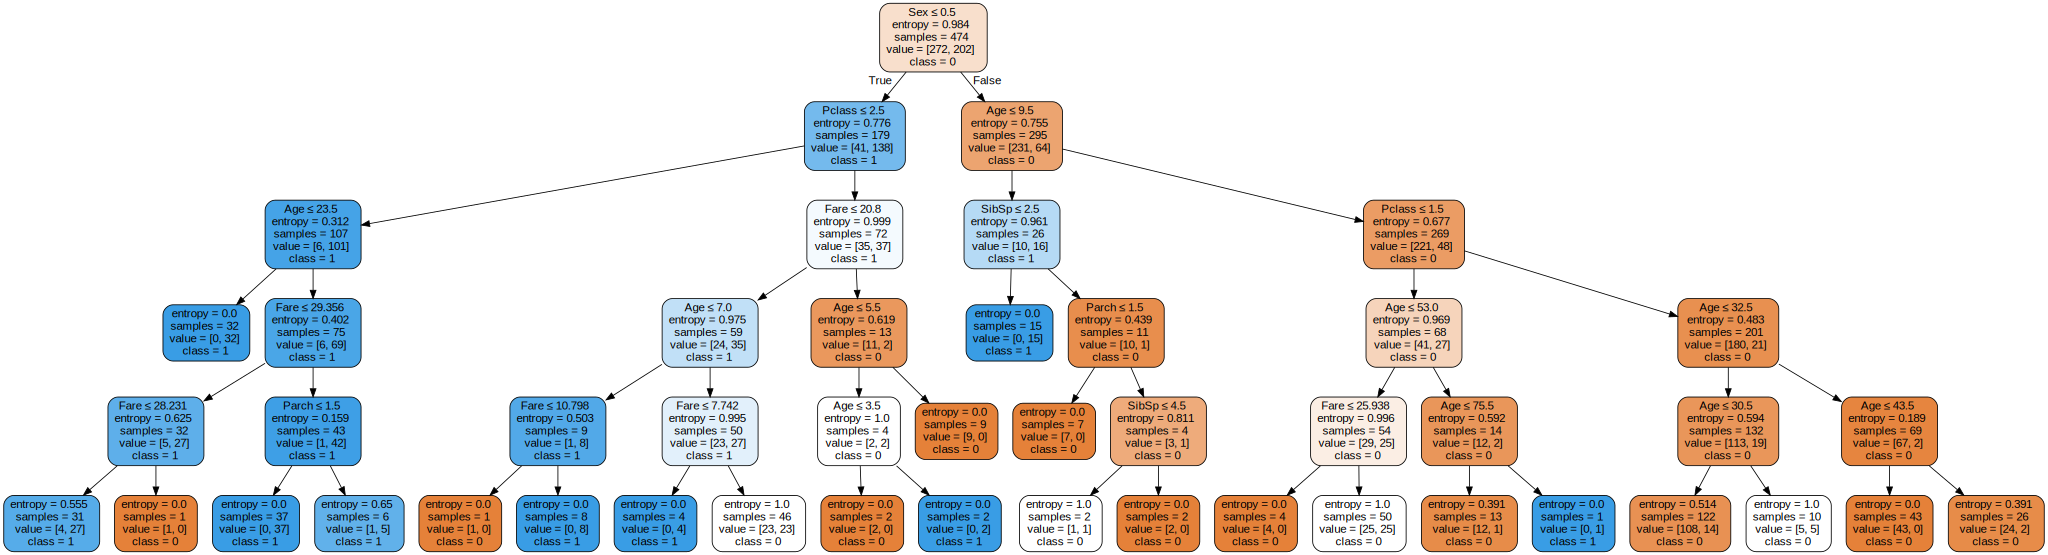

In [25]:
draw_tree(entropy_tree, entropy_X.columns, ['0','1'], 'titanic_entropy_depth')

# d)

In [26]:
# prunning
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=10)
entropy_tree, entropy_X = build_Tree(X_train, X_test, criterion='entropy', max_depth=5, min_samples_split=10, min_samples_leaf=10)

cross_validation(X, criterion='entropy', max_depth=5, min_samples_split=10, min_samples_leaf=5)
cross_validation(X, criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=5)

Classification using gini on TEST
[[134  29]
 [ 18  57]]
Score: 80.25%


Classification using gini on TRAIN
[[243  50]
 [ 29 152]]
Score: 83.33%


Classification using entropy on TEST
[[134  26]
 [ 18  60]]
Score: 81.51%


Classification using entropy on TRAIN
[[244  44]
 [ 28 158]]
Score: 84.81%


--------------------------------------
Cross validation using entropy
Test: 0 -> score: 73.91304347826086

Test: 1 -> score: 75.34246575342466

Test: 2 -> score: 85.36585365853658

Test: 3 -> score: 75.67567567567568

Test: 4 -> score: 80.59701492537313

Test: 5 -> score: 78.66666666666666

Test: 6 -> score: 73.97260273972603

Test: 7 -> score: 77.63157894736842

Test: 8 -> score: 85.96491228070175

Test: 9 -> score: 78.78787878787878

Final error: 78.59176929136125

--------------------------------------
Cross validation using gini
Test: 0 -> score: 75.0

Test: 1 -> score: 74.28571428571429

Test: 2 -> score: 86.66666666666667

Test: 3 -> score: 83.07692307692308

Test: 4 -> score: 84.05797

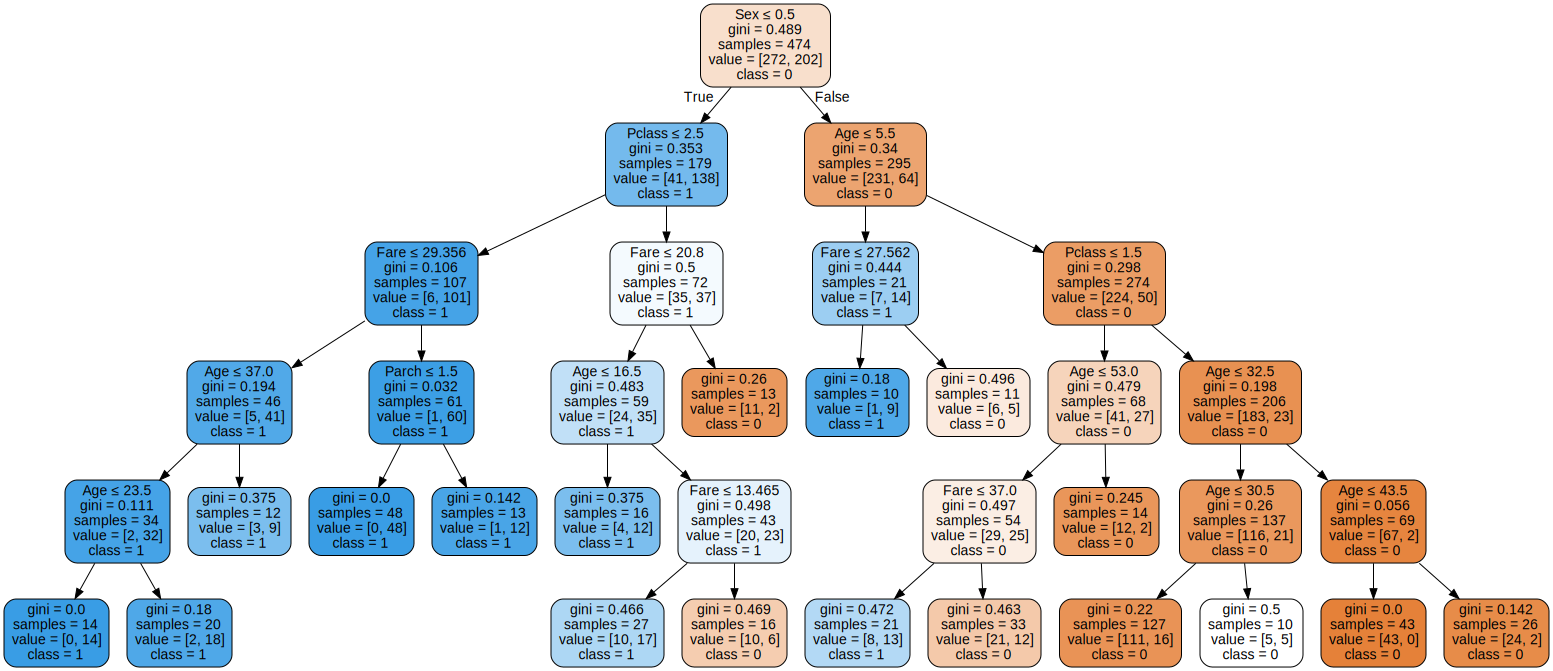

In [27]:
draw_tree(gini_tree, gini_X.columns, ['0','1'], 'titanic_gini_prunned')

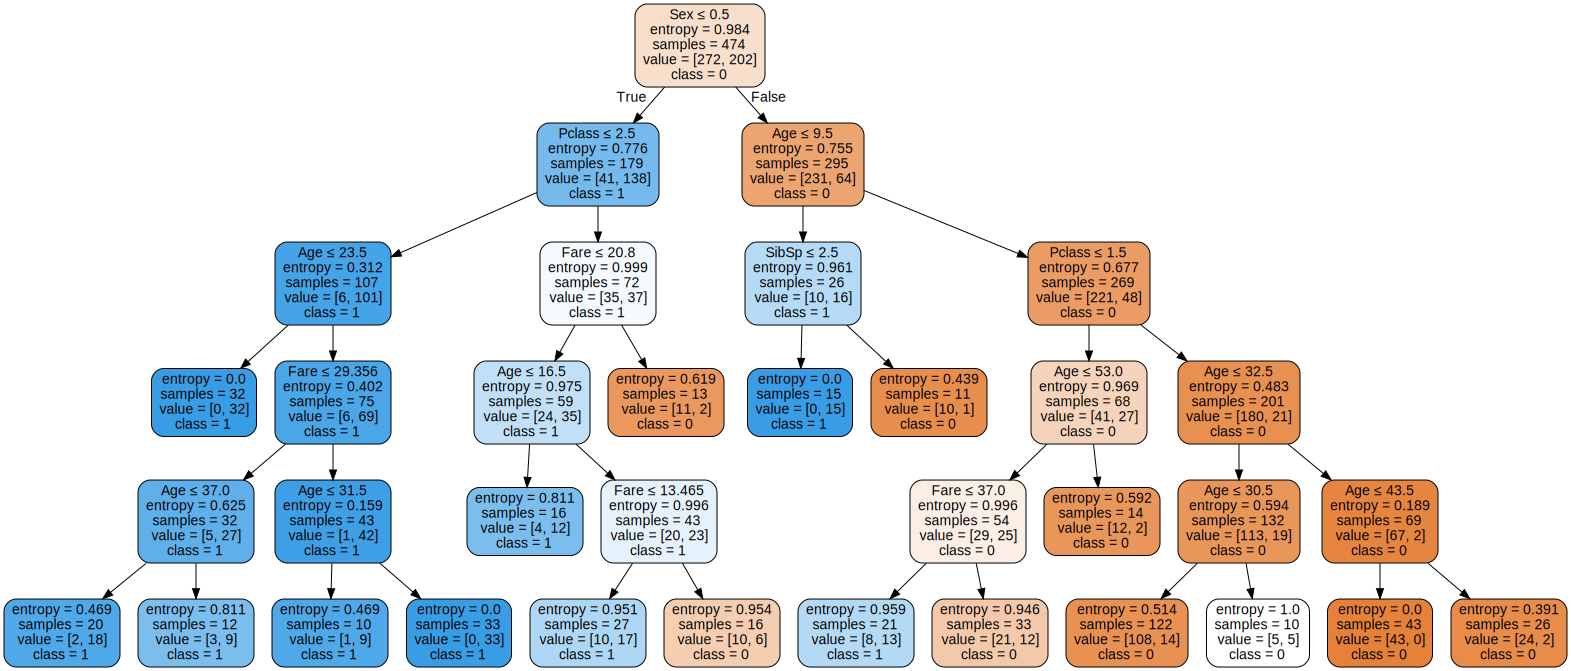

In [28]:
draw_tree(entropy_tree, entropy_X.columns, ['0','1'], 'titanic_entropy_prunned')

# Zadanie 3
**Random Forest i Extremely Randomized Trees**

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [30]:
# TITANIC
X_titanic_train, X_titanic_test = train_test_split(X, test_size=0.3333)
Y_titanic_train = X_titanic_train['Survived']
X_titanic_train = X_titanic_train.drop('Survived', axis=1)

Y_titanic_test = X_titanic_test['Survived']
X_titanic_test = X_titanic_test.drop('Survived', axis=1)

In [31]:
random_forest = RandomForestClassifier(n_estimators=20)
extra_random_forest = ExtraTreesClassifier(n_estimators=20)

random_forest.fit(X_titanic_train, Y_titanic_train)
extra_random_forest.fit(X_titanic_train, Y_titanic_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [32]:
print('Random Forest:')
print(metrics.confusion_matrix(random_forest.predict(X_titanic_test), Y_titanic_test))
print(f'Score: {random_forest.score(X_titanic_test, Y_titanic_test) * 100:.2f}%\n')

Random Forest:
[[125  27]
 [ 22  64]]
Score: 79.41%



In [203]:
print('Extremely Randomized Trees:')
print(metrics.confusion_matrix(extra_random_forest.predict(X_titanic_test), Y_titanic_test))
print(f'Score: {extra_random_forest.score(X_titanic_test, Y_titanic_test) * 100:.2f}%\n')

Extremely Randomized Trees:
[[123  33]
 [ 19  63]]
Score: 78.15%



In [207]:
# Iris
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [209]:
X_iris_train, X_iris_test = train_test_split(iris_df, test_size=0.3333)
Y_iris_train = X_iris_train['species']
X_iris_train = X_iris_train.drop('species', axis=1)

Y_iris_test = X_iris_test['species']
X_iris_test = X_iris_test.drop('species', axis=1)

In [210]:
random_forest = RandomForestClassifier(n_estimators=20)
extra_random_forest = ExtraTreesClassifier(n_estimators=20)

random_forest.fit(X_iris_train, Y_iris_train)
extra_random_forest.fit(X_iris_train, Y_iris_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [213]:
print('Random Forest:')
print(metrics.confusion_matrix(random_forest.predict(X_iris_test), Y_iris_test))
print(f'Score: {random_forest.score(X_iris_test, Y_iris_test) * 100:.2f}%\n')

Random Forest:
[[14  0  0]
 [ 0 19  1]
 [ 0  2 14]]
Score: 94.00%



In [215]:
print('Extremely Randomized Trees:')
print(metrics.confusion_matrix(extra_random_forest.predict(X_iris_test), Y_iris_test))
print(f'Score: {extra_random_forest.score(X_iris_test, Y_iris_test) * 100:.2f}%\n')

Extremely Randomized Trees:
[[14  0  0]
 [ 0 19  0]
 [ 0  2 15]]
Score: 96.00%

